In [6]:
import numpy as np
import urllib.request
import mnist
import matplotlib.pyplot as plt
import random
import math
from typing import Callable

# Dataset

## Load dataset (using python package mnist)

In [2]:
train_images=mnist.train_images()
train_labels=mnist.train_labels()
test_images=mnist.test_images()
test_labels=mnist.test_labels()

print(f"Size of train set = {len(train_images)}")
print(f"Size of test set = {len(test_images)}")
print(f"Image height, width = {train_images.shape[1]}, {train_images.shape[2]}")

Size of train set = 60000
Size of test set = 10000
Image height, width = 28, 28


## Visualise data

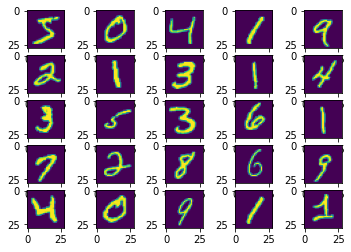

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1]


In [3]:
# Plot first few images from train set
fig=plt.figure()
vis_cols=5
vis_rows=5
for i in range(1,1+vis_cols*vis_rows):
    fig.add_subplot(vis_rows,vis_cols,i)
    plt.imshow(train_images[i-1,:,:])
plt.show()   

# Print corresponding labels just to check
print(train_labels[0:vis_cols*vis_rows])

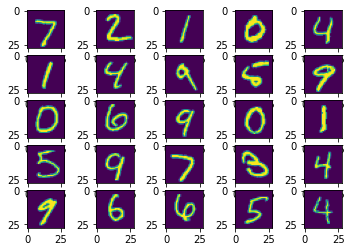

[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4]


In [4]:
# Plot first few images from test set
fig=plt.figure()
vis_cols=5
vis_rows=5
for i in range(1,1+vis_cols*vis_rows):
    fig.add_subplot(vis_rows,vis_cols,i)
    plt.imshow(test_images[i-1,:,:])
plt.show()   

# Print corresponding labels just to check
print(test_labels[0:vis_cols*vis_rows])

# Preprocessing

## Normalise images to be between -1.0 to 1.0

In [5]:
# Preprocess train and test set
# Normalise all images to [-1,1] (currently [0,255]
train_images=train_images.astype("float64")
test_images=test_images.astype("float64")
for i in range(len(train_images)):
    # [0,2]
    train_images[i,:,:]*=2.0/train_images[i,:,:].max()
    # [-1,1]
    train_images[i,:,:]-=1.0
for i in range(len(test_images)):
    # [0,2]
    test_images[i,:,:]*=2.0/test_images[i,:,:].max()*2.0
    # [-1,1]
    test_images[i,:,:]-=1.0

## Flatten images from 28x28 to 784x1

In [6]:
train_images_flatten=train_images.reshape(len(train_images),-1)
test_images_flatten=test_images.reshape(len(test_images),-1)

print(f"Before: {train_images.shape}, after: {train_images_flatten.shape}")
print(f"Before: {test_images.shape}, after: {test_images_flatten.shape}")

Before: (60000, 28, 28), after: (60000, 784)
Before: (10000, 28, 28), after: (10000, 784)


In [7]:
# Transpose such that each image now occupies a column, instead of a row
train_images_flatten=train_images_flatten.T
test_images_flatten=test_images_flatten.T

print(f"Current shape for train images: {train_images_flatten.shape}")
print(f"Current shape for test images: {test_images_flatten.shape}")

Current shape for train images: (784, 60000)
Current shape for test images: (784, 10000)


# Neural Network Model

## Neural network architecture

In [8]:
# Helper class to visualise neural network
# Taken from https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network

from matplotlib import pyplot
from math import cos, sin, atan

class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, neuron_radius):
        circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=False)
        pyplot.gca().add_patch(circle)


class Layer():
    def __init__(self, network, number_of_neurons, number_of_neurons_in_widest_layer):
        self.vertical_distance_between_layers = 6
        self.horizontal_distance_between_neurons = 2
        self.neuron_radius = 0.5
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += self.horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return self.horizontal_distance_between_neurons * (self.number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + self.vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = self.neuron_radius * sin(angle)
        y_adjustment = self.neuron_radius * cos(angle)
        line = pyplot.Line2D((neuron1.x - x_adjustment, neuron2.x + x_adjustment), (neuron1.y - y_adjustment, neuron2.y + y_adjustment))
        pyplot.gca().add_line(line)

    def draw(self, layerType=0):
        for neuron in self.neurons:
            neuron.draw( self.neuron_radius )
            if self.previous_layer:
                for previous_layer_neuron in self.previous_layer.neurons:
                    self.__line_between_two_neurons(neuron, previous_layer_neuron)
        # write Text
        x_text = self.number_of_neurons_in_widest_layer * self.horizontal_distance_between_neurons
        if layerType == 0:
            pyplot.text(x_text, self.y, 'Input Layer', fontsize = 12)
        elif layerType == -1:
            pyplot.text(x_text, self.y, 'Output Layer', fontsize = 12)
        else:
            pyplot.text(x_text, self.y, 'Hidden Layer '+str(layerType), fontsize = 12)

class NeuralNetwork():
    def __init__(self, number_of_neurons_in_widest_layer):
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.layers = []
        self.layertype = 0

    def add_layer(self, number_of_neurons ):
        layer = Layer(self, number_of_neurons, self.number_of_neurons_in_widest_layer)
        self.layers.append(layer)

    def draw(self):
        pyplot.figure()
        for i in range( len(self.layers) ):
            layer = self.layers[i]
            if i == len(self.layers)-1:
                i = -1
            layer.draw( i )
        pyplot.axis('scaled')
        pyplot.axis('off')
        pyplot.title( 'Neural Network architecture', fontsize=15 )
        pyplot.show()

class DrawNN():
    def __init__( self, neural_network ):
        self.neural_network = neural_network

    def draw( self ):
        widest_layer = max( self.neural_network )
        network = NeuralNetwork( widest_layer )
        for l in self.neural_network:
            network.add_layer(l)
        network.draw()

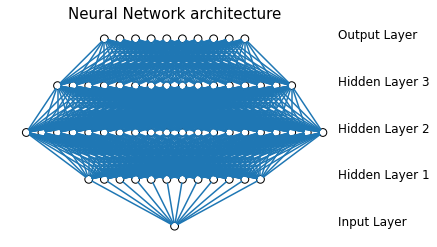

Input layer by right should have 28*28 neurons, but over here it's shown as 1 neuron so that the drawing can be shown nicely.
Also note that biases are not shown here.


In [9]:
# Number of hidden layers (excluding input layer and output layer)
# How to count layers https://datascience.stackexchange.com/questions/14027/counting-the-number-of-layers-in-a-neural-network
num_hidden_layers=3
# Layer width, assumed to be the same for all layers
hidden_layer_dim=[12,20,16] 

# Visualise current neural network
network = DrawNN( [1,*hidden_layer_dim,10] )
network.draw()

print("Input layer by right should have 28*28 neurons, but over here it's shown as 1 neuron so that the drawing can be shown nicely.")
print("Also note that biases are not shown here.")

# Initialise Weights and Biases

How to initialise weights and biases and why the method of initialisation matters
https://www.deeplearning.ai/ai-notes/initialization/

## Weights

Generally, Xavier initialisation works better for layers with sigmoid activation, while He initialisation works better for layers with ReLU activation. Both of the aforementioned weights initialisation techniques try to match the variance of the outputs of a layer with its inputs, and the way to achieve that depends on the activation function. Xavier initialisation was designed for sigmoid and He initialisation was designed for ReLU.   

Xavier and He initialisation were proposed here http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf and here https://arxiv.org/pdf/1502.01852v1.pdf respectively!

In [10]:
# This function initialises weights for a layer using xavier initialisation
def xavier_weights(fan_in, fan_out):
    # What is fan_in and fan_out? https://stackoverflow.com/questions/42670274/how-to-calculate-fan-in-and-fan-out-in-xavier-initialization-for-neural-networks
    
    scale = 1/max(1., (fan_in+fan_out)/2.)
    limit = math.sqrt(3.0 * scale)
    weights = np.random.uniform(-limit, limit, size=(fan_in,fan_out))
    return weights

In [11]:
# He initialisation
def he_weights(fan_in:int, fan_out:int)->np.ndarray:
    std=(2.0/fan_in)**0.5
    weights=np.random.randn(fan_in,fan_out)
    # scale weights to desired range
    weights=weights*std
    return weights

### Initialise weights for all layers

Note that the total number of layers will be num_hidden_layers+1. Look at the diagram of the neural network and it will be clear.

In [12]:
# Initialise all weights
# W=[w0, w1, w2, ...]
# w0_ij (i is row, j is col) corresponds to the weight between node j in the previous layer
# and node i in the next layer
W=[xavier_weights(hidden_layer_dim[0],28*28)]
for i in range(num_hidden_layers-1):
    W.append(xavier_weights(hidden_layer_dim[i+1],hidden_layer_dim[i]))
W.append(xavier_weights(10,hidden_layer_dim[-1]))

print(f"Number of weight matrices (corresponds to number of layers) = {len(W)}")
print(f"Dimension of weight matrix for each layer = {[x.shape for x in W]}")

Number of weight matrices (corresponds to number of layers) = 4
Dimension of weight matrix for each layer = [(12, 784), (20, 12), (16, 20), (10, 16)]


## Biases
Why do we need biases? Biases are analogous to constants in functions. Imagine trying to fit data on the scatter plot below with y=ax vs y=ax+c. The c in y=ax+c gives our model the flexibility to translate and potentially get a better fit. It increases our solution space and removes the need for our model to pass through the origin.

In the context of neural networks, biases give activation functions the ability to translate.  

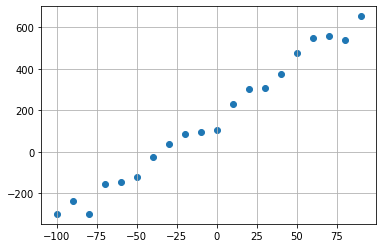

In [26]:
foo_x=np.array(range(-100,100,10))
foo_y=foo_x*5+200+(np.random.randn(*(foo_x.shape)))*50
plt.scatter(foo_x,foo_y)
plt.grid()

### Initialise biases for all layers

In [13]:
# Biases are initialised as zeros
B=[]
for i in range(num_hidden_layers):
    B.append(np.zeros([hidden_layer_dim[i],1]))
B.append(np.zeros([10,1]))

print(f"Number of bias matrices (corresponds to number of layers) = {len(B)}")
print(f"Dimension of bias matrix for each layer = {[x.shape for x in B]}")

Number of bias matrices (corresponds to number of layers) = 4
Dimension of bias matrix for each layer = [(12, 1), (20, 1), (16, 1), (10, 1)]


## Function to initialise both weights and biases

In [14]:
def init_wandb(dim_input:int, hidden_layers_dim:list[int], num_classes:int, weight_init_func:Callable)->tuple[list[np.ndarray],list[np.ndarray]]:
    num_hidden_layers=len(hidden_layers_dim)
    
    # Initialise weights
    W=[weight_init_func(hidden_layers_dim[0],dim_input)]
    for i in range(num_hidden_layers-1):
        W.append(weight_init_func(hidden_layers_dim[i+1],hidden_layers_dim[i]))
    W.append(weight_init_func(10,hidden_layers_dim[-1]))
    
    # Initialise biases
    B=[]
    for i in range(num_hidden_layers):
        B.append(np.zeros([hidden_layers_dim[i],1]))
    B.append(np.zeros([num_classes,1]))
    
    return (W,B)

In [15]:
W,B=init_wandb(train_images_flatten.shape[0],hidden_layer_dim,10,xavier_weights)
print(f"Number of weight matrices (corresponds to number of layers) = {len(W)}")
print(f"Dimension of weight matrix for each layer = {[x.shape for x in W]}")
print(f"Number of bias matrices (corresponds to number of layers) = {len(B)}")
print(f"Dimension of bias matrix for each layer = {[x.shape for x in B]}")

Number of weight matrices (corresponds to number of layers) = 4
Dimension of weight matrix for each layer = [(12, 784), (20, 12), (16, 20), (10, 16)]
Number of bias matrices (corresponds to number of layers) = 4
Dimension of bias matrix for each layer = [(12, 1), (20, 1), (16, 1), (10, 1)]


# Training

## Loss function

The idea of a loss function is to measure how different our prediction is from the ground truth. Categorical cross entropy loss is are typically chosen for multi-class classifiers. It's defined as:
$$L=-\Sigma_i (y_i\times \log_2(p_i))$$
, where $y$ is a one-hot encoded ground truth vector and p is the prediction vector.

The intuition for this loss function is that for a ground truth vector $\boldsymbol{y}=[0,1,0,0]^T$ (this means the second class is the correct class), we also want the second element of $\boldsymbol{p}$ to be as close to $1$ as possible. If $p_2<1$, then $-log(p_2)$ will be positive. The further it is away from 1, the more positive it will be, ie. the greater the loss.

In [16]:
 def categorical_cross_entropy_loss(gt_class_index:list[int], pred:np.ndarray):
    
    # Prevent any 0 element in pred
    pred+=1e-9
    num_classes=pred.shape[0]
    
    assert len(gt_class_index)==pred.shape[1]
    
    losses=[]
    for i in range(len(gt_class_index)):
        gt=np.zeros([num_classes,1])
        gt[gt_class_index[i]]=1

        loss=(np.matmul(gt.T, -np.log2(pred[:,i,None])))
        
        losses.append(float(loss[0]))
  
    return losses

## Forward propagation

### Activation functions

Activation functions are non-linear functions included at every layer! Without them, the final model is just a linear regression model. Without a non-linear activation function, no matter how many layers deep the neural network is, it is effectively still a single layer perceptron that is only capable of learning a linear function. Activation functions introduces non-linearity and allows the model to learn complex (non-linear) functions. Here are some examples of activation functions that will be used.

#### ReLU activation function
ReLU is called Rectified Linear Unit. Basically positive elements in the input are preserved, while negative inputs are set to 0:
$$ReLU(\boldsymbol{x})=max(0.0,\boldsymbol{x})$$
ReLU is typically chosen over sigmoid as neural networks with ReLU are easier to train as compared with those with sigmoid.

In [17]:
def ReLU(x):
    return x.clip(min=0)

#### Softmax activation function
Softmax is also known as a "softer version of argmax"! Intuitively, softmax is "fairer" as it doesn't penalise values that are just slightly lower than the max value. Just imagine a vector $[100,101,2,4,3]$ going through argmax to become $[0,1,0,0,0]$. On the other hand, softmax is less harsh but still preserves rank (the vector becomes $[0.27,0.73,0,0,0]$. Additionally, softmax is continuous and differentiable so we can do gradient descent to optimise the loss function (I believe using argmax would pose numerical instability?)

Formula of softmax is:
$$softmax(x_i)=\frac{e^{x_i}}{\Sigma_{j=1}^ne^{x_j}}$$
, where n is the length of $\boldsymbol{x}$ or the number of classes.

In [18]:
# Softmax
def softmax(x):
    if (x.ndim>1) and x.shape[1]>1:
        output=np.zeros(x.shape)
        for i in range(x.shape[1]):
            e_x=np.exp(x[:,i]-np.max(x[:,i]))
            output[:,i]=e_x/e_x.sum()
        return output
    else:
        e_x=np.exp(x-np.max(x))
        return e_x/e_x.sum()

Let's define the activation function we want at each layer. We will use ReLU for all the hidden layers except for the final layer, which we will use softmax. Softmax is used for the final layer as this is a multi-class classification problem where we want to predict one class out of many classes.

In [19]:
Act=[]
for i in range(num_hidden_layers):
    Act.append(ReLU)
# Final layer will be softmax
Act.append(softmax)

print(f"Activation functions chosen are: {Act}")

Activation functions chosen are: [<function ReLU at 0x000002868034B0A0>, <function ReLU at 0x000002868034B0A0>, <function ReLU at 0x000002868034B0A0>, <function softmax at 0x000002868034B400>]


### Propagating one image through a single layer

The code below shows propagation through a single layer with a single image using the following relations:
$$z^1=w^1\times x+b^1$$
$$a^1=g^1(z^1)$$
, where superscript represents the layer number, $x$ is the input image, and $g$ is the activation function.

In [20]:
z_1=np.matmul(W[0],train_images_flatten[:,0,None])+B[0]
a_1=Act[0](z_1)

print(f"Values of the nodes in the first hidden layer are:\n {a_1}")

Values of the nodes in the first hidden layer are:
 [[3.12033317]
 [0.7548036 ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [1.83203055]
 [0.20241401]
 [0.        ]
 [0.        ]
 [0.13509928]]


### Propagating multiple images through a single layer

Fortunately, section 5.3.2 can be easily extended to propagate multiple images. Simply replace $x$ (a vertical vector from a single image) with $X$, a matrix that consists of multiple vertical vectors (concatenated horizontally):
$$Z^1=w^1\times X+b^1$$
$$A^1=g^1(Z^1)$$
Note: There's some overloading going on in the formula above! "+" is overloaded to add vector to matrix.

In [21]:
# Propagate 5 images through the first layer
Z_1=np.matmul(W[0],train_images_flatten[:,0:5])+B[0]
A_1=Act[0](Z_1)

print(f"Values of the nodes in the first hidden layer for 5 images are:\n {A_1}")

Values of the nodes in the first hidden layer for 5 images are:
 [[3.12033317 2.86942822 4.13966418 2.50248285 3.6636203 ]
 [0.7548036  0.22690161 3.18408686 1.83201608 2.00286535]
 [0.         0.         0.56902605 0.14825123 0.22286582]
 [0.         0.         0.86034648 1.0012087  0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.06893342 0.76376784 0.        ]
 [0.         0.         0.         0.         0.        ]
 [1.83203055 0.         0.58122831 0.65777753 0.        ]
 [0.20241401 1.35537088 0.97111882 0.93303392 0.55937771]
 [0.         0.         0.         0.         0.20822772]
 [0.         0.         0.         0.         0.        ]
 [0.13509928 0.         1.05329145 0.03860907 0.        ]]


### Propagating multiple images through all layers

To propagate through multiple layers, simply do:
$$Z^i=w^i\times A^{i-1}+b^i$$
$$A^i=g^i(Z^i)$$
, where $A^{0}=X$

In [22]:
# Propagate 5 images through the first layer
Z_1=np.matmul(W[0],train_images_flatten[:,0:5])+B[0]
A_1=Act[0](Z_1)
print(f"Shape of A_1: {A_1.shape}")

# Through second layer
Z_2=np.matmul(W[1],A_1)+B[1]
A_2=Act[1](Z_2)
print(f"Shape of A_2: {A_2.shape}")

# Through third layer
Z_3=np.matmul(W[2],A_2)+B[2]
A_3=Act[2](Z_3)
print(f"Shape of A_3: {A_3.shape}")

# Through fourth layer
# A_4 is the confidence for each class!
Z_4=np.matmul(W[3],A_3)+B[3]
A_4=Act[3](Z_4)
print(f"Shape of A_4: {A_4.shape}")

Shape of A_1: (12, 5)
Shape of A_2: (20, 5)
Shape of A_3: (16, 5)
Shape of A_4: (10, 5)


The function below does the same thing as the cell above, but without having to type layer by layer manually.

In [23]:
def forward(train_data:np.array,act_type:list[Callable],weights:list[np.ndarray],bias:list[np.ndarray],verbose=False)->np.ndarray:
    """Performs forward propagation.
    Returns all activations (including last layer of activations, ie. predictions).
    """
    num_layers=len(act_type)
    num_classes=weights[-1].shape[0]
    assert len(weights)==num_layers
    
    # Make train_data a 2D numpy if it is not already one
    if train_data.ndim==1:
        train_data=train_data[:,None]
    num_images=train_data.shape[1]
    
    if verbose:
        print(f"Number of images = {num_images}")
    
    # Initialise output
    A=[]
    
    for l in range(num_layers):
        if l==0:
            Z=np.matmul(weights[l],train_data)+bias[l]
            A.append(act_type[l](Z))
        else:
            Z=np.matmul(weights[l],A[l-1])+bias[l]
            A.append(act_type[l](Z))
        if verbose:
            print(f"Layer {l}, shape of activation: {A[l].shape}")
    
    return A

In [24]:
temp_activations=forward(train_images_flatten[:,0:5],Act,W,B,verbose=True)
# Just to prove that the function does the same thing
print(A_4==temp_activations[-1])

Number of images = 5
Layer 0, shape of activation: (12, 5)
Layer 1, shape of activation: (20, 5)
Layer 2, shape of activation: (16, 5)
Layer 3, shape of activation: (10, 5)
[[ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]


## Backpropagation

Backpropagation is an algorithm used for training feedforward neural networks. The idea is figure out an almost optimal way to adjust all the weights in the neural network, such that its predictions would be closer to the ground truth. 

### Backpropagation at final layer

The propagation of information on how much to adjust for all the weights starts from the final layer. Intuitively, this makes sense as the prediction happens in the final layer, and how the weights in the layers further upstream will be modified to improve performance should depend on how well the prediction is in the final layer. This is why the algorithm is called BACKPROPAGATION.

First, we want to figure out how to vary weights in the final layer $L$ to reduce error between prediction and ground truth. To achieve that, we need to know $\frac{\partial e(\boldsymbol{w})}{\partial w_{ij}^L}$, ie. how error between prediction and ground truth changes with respect to each component of the final layer weights ($e$ is the output of the loss function, which will be categorical cross entropy in this notebook).

#### Looking at $w_{11}^L$ only

Let's just only look at $\frac{\partial e(\boldsymbol{w})}{\partial w_{11}^L}$, ie. how a single weight component $w_{11}^L$ affect the final error. To figure out $\frac{\partial e(\boldsymbol{w})}{\partial w_{11}^L}$, we will need to use chain rule (illustration below):
$$\frac{\partial e(\boldsymbol{w})}{\partial w_{11}^L}=\frac{\partial e(\boldsymbol{w})}{\partial z_1^L} \frac{\partial z_1^L}{\partial w_{11}^L}$$
Since
$$z_1^L=w_{11}^{L}a_1^{L-1}+w_{12}^{L}a_2^{L-1}+...+w_{1n}^{L}a_n^{L-1}+b_1^L$$
We have $$\frac{\partial z_1^L}{\partial w_{11}^L}=a_1^{L-1}$$
$\frac{\partial e(\boldsymbol{w})}{\partial z_1^L}$ will depend on both the loss function and activation function used.

<img src="images/backprop_diagram.jpeg" width="500"/>

### Gradient of common loss functions and activation functions

#### $\frac{\partial e(\boldsymbol{w})}{\partial z_i^L}$ for softmax+categorical cross entropy loss function
$$\frac{\partial e(\boldsymbol{w})}{\partial z_i^L}=a_i-y_i$$
or equivalently,
$$\frac{\partial e(\boldsymbol{w})}{\partial \boldsymbol{z}^L}=\boldsymbol{a}-\boldsymbol{y}$$
Proof can be found at https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1. 

This result makes intuitive sense. Suppose we have $\boldsymbol{z}^L=[10,0,2]^T$, and $\boldsymbol{y}=[0,1,0]^T$ (ie. the correct prediction should be the second class), the categorical cross entropy error (or loss value) $e=$. We get $\boldsymbol{a}=softmax(\boldsymbol{z})=[0.99962,0.00005,0.00035]^T$, categorical cross entropy error $e=11.5$, and $\boldsymbol{a}-\boldsymbol{y}=[0.99962,-0.9995,0.00035]^T$. Now, to reduce $e$, we should nudge $z$ slightly in the direction $-\frac{\partial e(\boldsymbol{w})}{\partial \boldsymbol{z}^L}$. This is because the gradient points to the direction that will increase $e$ the quickest, so to decrease $e$, the quickest direction to nudge $z$ will be the negative gradient. Now let's nudge $\boldsymbol{z}$:
$$\boldsymbol{z}_{new}=\boldsymbol{z}-10.0\times(\boldsymbol{a}-\boldsymbol{y})$$
and we see that we get $\boldsymbol{z}_{new}=[0.0038,9.9995,1.9966]^T$. Right away, we can observe that the second value became bigger while the rest became smaller. $\boldsymbol{a}_{new}=[0.00005,0.99962,0.00033]^T$, $e_{new}=0.0005$.

#### Gradient of ReLU $\frac{\partial a_i}{\partial z_j}$
$$\frac{\partial a_i}{\partial z_j}=
\begin{cases}
    0, & \text{if }z_j\leq0\\
    1, & \text{otherwise}
\end{cases}$$

Later on at [Problem of vanishing gradients](#vanishing_grad), we will discuss how this property of ReLU helps to solve the problem of vanishing gradients.

### Backpropagation at second last layer and onwards

#### Second last layer
Previously, we found out how to nudge weights at the last layer (layer $L$) to reduce prediction error. In order to reduce error, other than modifying the weights at the last layer, we could also modify the inputs into the last layer, which is $\boldsymbol{a}^{L-1}$. However, the last layer has no control over $\boldsymbol{a}^{L-1}$. To modify that, we would have to propagate last layer's desired nudge for $\boldsymbol{a}^{L-1}$ down to the second last layer, and then control $\boldsymbol{a}^{L-1}$ by nudging the weights at the second last layer $\boldsymbol{w}^{L-1}$. This is called backpropagation. By using the chain rule (similar to the last layer), gradient information at the second last layer:
$$\begin{align*}
\frac{\partial e(\boldsymbol{w})}{\partial w_{ij}^{L-1}}=& \frac{\partial e(\boldsymbol{w})}{\partial z_i^{L-1}}\times \frac{\partial z_i^{L-1}}{\partial w_{ij}^{L-1}}\\
=& \frac{\partial e(\boldsymbol{w})}{\partial z_i^{L-1}}\times a_j^{L-2}
\end{align*}$$
To find $\frac{\partial e(\boldsymbol{w})}{\partial \boldsymbol{z}_i^{L-1}}$, information has to be propagated from the last layer:
$$\begin{align*}
\frac{\partial e(\boldsymbol{w})}{\partial z_i^{L-1}}
=& \Sigma_{k=1}^{N^L} \left( \frac{\partial e}{\partial z_k^L}\times 
\frac{\partial z_k^L}{\partial a_i^{L-1}}\times 
\frac{\partial a_i^{L-1}}{\partial z_i^{L-1}}\right) \\
=& \Sigma_{k=1}^{N^L} \left( \frac{\partial e}{\partial z_k^L}\times 
w_{ki}^L\times 
\frac{\partial a_i^{L-1}}{\partial z_i^{L-1}}\right)
\end{align*}$$
If the activation function at this layer is ReLU, then $\frac{\partial a_i^{L-1}}{\partial z_i^{L-1}}=0$ or $1$. 
The formula for $\frac{\partial e(\boldsymbol{w})}{\partial \boldsymbol{z}_i^{L-1}}$ might look confusing, but it makes intuitive sense. There's summation of terms across layer $L$ as $z_i^{L-1}$ influences all of the terms in layer $L$! Another way to think about this is that the last layer has some ideas on how $\boldsymbol{z}^L$ should be modified, and since $z_i^{L-1}$ influences $z_1^L, z_2^L, ..., z_{N^L}^L$, all of the wishes of layer L should be fully conveyed to $z_i^{L-1}$ of the second last layer. 

#### Any layer
The general formula for $\frac{\partial e(\boldsymbol{w})}{\partial w_{ij}^{l}}$ for any layer $l$ is:
$$\begin{align*}
\frac{\partial e(\boldsymbol{w})}{\partial w_{ij}^{l}}
=& \delta_i^{l}\times a_j^{l-1}
\end{align*}$$
where 
$$\begin{align*}
\delta_i^l
=&\Sigma_{k=1}^{N^{l+1}} \left( \frac{\partial e}{\partial z_k^{l+1}}\times 
w_{ki}^{l+1}\times 
\frac{\partial a_i^{l}}{\partial z_i^{l}}\right) \\
=&\Sigma_{k=1}^{N^{l+1}} \left( \delta_k^{l+1}\times 
w_{ki}^{l+1}\times 
\frac{\partial a_i^{l}}{\partial z_i^{l}}\right) \\
=&\frac{\partial a_i^{l}}{\partial z_i^{l}} \Sigma_{k=1}^{N^{l+1}} \left( \delta_k^{l+1}\times 
w_{ki}^{l+1} \right)
\end{align*}$$

#### Bias update
Finding the gradient of loss with respect to bias is very similar to that of the weights:
$$ \begin{align*}
\frac{\partial e}{\partial b_i^l}
=& \frac{\partial e}{\partial z_i^l}\times \frac{\partial z_i^l}{\partial b_i^l} \\
=& \delta_i^l \times 1
\end{align*}$$
, $\frac{\partial z_i^l}{\partial b_i^l}=1$ as $z_i^l=w_{i1}^{l}a_1^{l-1}+w_{i2}^{l}a_2^{l-1}+...+w_{in}^{l}a_n^{l-1}+b_i^l$

In [25]:
def backpropagate(train_data:np.array,act_type:list[Callable],activations:list[np.array],weights:list[np.array],ground_truth_index:list[int],verbose:bool=False)->tuple[list[np.array]]:
    """Performs backpropagation.
    Returns gradient associated with each weight, and bias.
    """
    num_layers=len(act_type)
    num_classes=weights[-1].shape[0]
    assert len(activations)==num_layers
    assert len(weights)==num_layers
    # Make sure the number of classes is consistent with ground_truth_index
    for i in range(len(ground_truth_index)):
        assert ground_truth_index[i]<num_classes
    
    # Make activation a 2D numpy if it is not already one
    # If activation has 5 columns, it means it consists of 5 images
    for i in range(num_layers):
        if activations[i].ndim==1:
            activations[i]=activations[i][:,None]
    num_images=activations[-1].shape[1]
    assert len(ground_truth_index)==num_images
    
    if verbose:
        print(f"Num layers={num_layers}")
        print(f"Num classes={num_classes}")
        print(f"Num images={num_images}")
    
    # Make train_data a 2D numpy if it is not already one
    if train_data.ndim==1:
        train_data=train_data[:,None]
    assert train_data.shape[1]==num_images
    
    # Initialise output
    grad=[]
    for i in range(num_layers):
        grad.append(np.array(weights[i].shape))
        
    # Initialise intermediate value, delta
    delta=[]
    for i in range(num_layers):
        delta.append(np.zeros([weights[i].shape[0],num_images]))
        
    # Find delta for last layer
    if (act_type[-1]==softmax):
        # Assume loss function is categorical cross entropy loss
        # delta for last layer is a-y
        y=np.zeros([num_classes,num_images])
        y[ground_truth_index,list(range(num_images))]=1.0
        delta[-1]=activations[-1]-y
        
        # if verbose:
        #     print(f"One-hot ground truth={y}")
    else:
        raise ValueError("Activation type for last layer is not implemented yet.")
        
    # Fill in delta from second last layer to first layer
    for l in range(num_layers-2,-1,-1):
        if (act_type[l]==ReLU):
            for im_i in range(num_images):
                temp=np.sum(delta[l+1][:,im_i,None]*W[l+1],0)
                
                # Gradient of ReLU = 1 if z>0, else 0 (can tell if z>0 from activation)
                z=activations[l][:,im_i,None]
                z[z>0]=1.0
                temp=np.multiply(temp[:,None],z)
                delta[l][:,im_i,None]=temp
        else:
            print(f"Activation type for layer {l} is {act_type[l]}")
            raise ValueError("Activation type for layer is not implemented yet.")
        
    # Find gradient from each each image, then average gradient across the images
    for l in range(num_layers-1,-1,-1):
        if l==0:
            temp=np.zeros([delta[l].shape[0],train_data.shape[0]])
        else:
            temp=np.zeros([delta[l].shape[0],activations[l-1].shape[0]])
        for im_i in range(num_images):
            if l==0:
                # Gradient info from 1 image
                grad_per_image=np.outer(delta[l][:,im_i,None],train_data[:,im_i,None])
                temp+=grad_per_image
            else:
                # Gradient info from 1 image
                grad_per_image=np.outer(delta[l][:,im_i,None],activations[l-1][:,im_i,None])
                temp+=grad_per_image
        grad[l]=temp/num_images
        
    # Fill in gradient of loss wrt to bias (which is actually just delta)
    grad_bias=[]
    for l in range(num_layers):
        grad_bias.append(np.sum(delta[l],1)/num_images)
        # Make grad_bias[l] a 2D numpy
        grad_bias[l]=grad_bias[l][:,None]
            
    return (grad, grad_bias)

## Gradient descent
With the gradient of error wrt weights $\frac{\partial e}{\partial w_{ij}^l}$ and biases $\frac{\partial e}{\partial b_{i}^l}$, we can now nudge the weights and biases with the aim of reducing the error. The direction that we are nudging to reduce the error as quickly as possible will be the negative of the gradients! This process of nudging is also called gradient descent.

We could go through the entire training set, find the gradients for every image in the training set, average the gradients, and then nudge the weights and biases in the direction of negative average gradient. But that will be slow. Instead, we will use something called stochastic gradient descent.

### Stochastic gradient descent
The idea is to split the training set into multiple batches of say 16 images per batch. Then we would find the gradients for every image in each batch, average the gradients within a batch, then nudge the weights and biases in the direction of negative average gradient. Then we repeat the process for the other batches, until all the images have been passed through the neural network. 
\
The image below compares what is actually happening between gradient descent and stochastic gradient descent (taken from 2Blue1Brown, left for gradient descent, right for stochastic gradient descent). 2Blue1Brown has a very good analogy for gradient descent vs stochastic gradient descent: "If you were to plot the trajectory of your network [,that's being optimised using stochastic gradient descent,] under the relevant cost surface, 
it would be a little more like a drunk man stumbling aimlessly down a hill, but taking quick steps, rather than a carefully calculating man determining the exact downhill direction of each step, before taking a very slow and careful step in that direction.

<img src="images/gradient_descent_vs_sgd.png">

The function below helps to split up training set into multiple batches.

In [26]:
# Split dataset into batches
# Function returns index only
def get_batch_indices(total_num_images, batch_size=32):
    num_batches=int(total_num_images/batch_size) 
    temp_list=list(range(total_num_images))
    # Shuffle list
    random.shuffle(temp_list)
    
    indices=[temp_list[i*batch_size:(i+1)*batch_size] for i in range(num_batches)]
    
    # Put the leftovers in the last batch
    indices[-1].extend(temp_list[num_batches*batch_size:])
    
    return indices

## Hyperparameters

In [27]:
lr=0.01
batch_size=64
num_epochs=100

## Putting every thing together
Let's train!

### Further split training set into training and validation set
Validation set will not be used to train at all, but it will be used to help us evaluate the performance of the network during training. During training, prediction loss on the validation set should decrease. When prediction loss starts to increase consistently, then overfitting has occured, and it is time to terminate training. 

In [35]:
# Flatten training images
train_images_flatten=train_images.reshape(len(train_images),-1)
test_images_flatten=test_images.reshape(len(test_images),-1)

# Split training set into training and validation set
ten_percent_cutoff = int(len(train_images)/10)
val_images_flatten=train_images_flatten[0:ten_percent_cutoff,:]
train_images_flatten=train_images_flatten[ten_percent_cutoff:,:]
val_labels_new=train_labels[0:ten_percent_cutoff]
train_labels_new=train_labels[ten_percent_cutoff:]
test_labels_new=test_labels

# Transpose such that each image now occupies a column, instead of a row
train_images_flatten=train_images_flatten.T
test_images_flatten=test_images_flatten.T
val_images_flatten=val_images_flatten.T

# Count number of images in each set
num_train_set=train_images_flatten.shape[1]
num_val_set=val_images_flatten.shape[1]
num_test_set=test_images_flatten.shape[1]
print(f"Training set size = {num_train_set}")
print(f"Validation set size = {num_val_set}")
print(f"Test set size = {num_test_set}")

Training set size = 54000
Validation set size = 6000
Test set size = 10000


### Consolidate all initialisations for easy access

In [36]:
# Number of hidden layers (excluding input layer and output layer)
# How to count layers https://datascience.stackexchange.com/questions/14027/counting-the-number-of-layers-in-a-neural-network
num_hidden_layers=3
# Individual layer width for each hidden layer
hidden_layers_dim=[20,20,10]

# Activation function used in each layer
Act=[]
for i in range(num_hidden_layers):
    Act.append(ReLU)
Act.append(softmax)

# Initialise weights and biases
W,B=init_wandb(train_images_flatten.shape[0],hidden_layers_dim,10,he_weights)

### Training loop

In [37]:
# Forward propagation
for epoch_index in range(num_epochs):
    print(f"Training epoch {epoch_index}/{num_epochs-1}")
    
    # Split training images into batches
    batch_indices=get_batch_indices(total_num_images=num_train_set, batch_size=batch_size)
    
    for batch_index in range(len(batch_indices)):
        # if batch_index%100==0:
        #     print(f"Batch {batch_index}/{len(batch_indices)-1}")
        A=forward(train_images_flatten[:,batch_indices[batch_index]],Act,W,B)
        grad_w,grad_b=backpropagate(train_images_flatten[:,batch_indices[batch_index]],Act,A,W,list(train_labels_new[batch_indices[batch_index]]))

        # Stochastic gradient descent
        for l in range(len(Act)):
            W[l]=W[l]-lr*grad_w[l]
            B[l]=B[l]-lr*grad_b[l]
        
    # Try predicting for all the training images and validation images
    A_train=forward(train_images_flatten,Act,W,B)
    A_val=forward(val_images_flatten,Act,W,B)
    
    # Calculate average loss
    losses=categorical_cross_entropy_loss(list(train_labels_new),A_train[-1])
    train_loss=sum(losses)/len(losses)
    losses=categorical_cross_entropy_loss(list(val_labels_new),A_val[-1])
    val_loss=sum(losses)/len(losses)
    
    # Calculate accuracy
    train_acc=sum(np.argmax(A_train[-1],axis=0)==train_labels_new)/num_train_set
    val_acc=sum(np.argmax(A_val[-1],axis=0)==val_labels_new)/num_val_set
    
    print(f"val_loss: {val_loss}, loss: {train_loss}, val_acc: {val_acc}, acc: {train_acc}")

Training epoch 0/99
val_loss: 2.6074698874023277, loss: 2.6277015615560253, val_acc: 0.3105, acc: 0.30733333333333335
Training epoch 1/99
val_loss: 2.10768838635221, loss: 2.132071000594817, val_acc: 0.455, acc: 0.4455
Training epoch 2/99
val_loss: 1.7673577095590718, loss: 1.8071078950400639, val_acc: 0.5815, acc: 0.5774259259259259
Training epoch 3/99
val_loss: 1.4965193249464845, loss: 1.5266026237598753, val_acc: 0.6778333333333333, acc: 0.6792592592592592
Training epoch 4/99
val_loss: 1.3167929153546578, loss: 1.3565695861499345, val_acc: 0.7345, acc: 0.730037037037037
Training epoch 5/99
val_loss: 1.2047615534498695, loss: 1.2453606822990575, val_acc: 0.7638333333333334, acc: 0.7519629629629629
Training epoch 6/99
val_loss: 1.1432403758725334, loss: 1.184117104649656, val_acc: 0.7778333333333334, acc: 0.766962962962963
Training epoch 7/99
val_loss: 1.0783979905260672, loss: 1.117975790107175, val_acc: 0.7941666666666667, acc: 0.7816851851851851
Training epoch 8/99
val_loss: 1.033

### Performance on test set

In [42]:
# Make predictions
A_test=forward(test_images_flatten,Act,W,B)

# Results
# Calculate average loss
losses=categorical_cross_entropy_loss(list(test_labels_new),A_test[-1])
test_loss=sum(losses)/len(losses)

# Calculate accuracy
matched_label=(np.argmax(A_test[-1],axis=0)==test_labels_new)
test_acc=sum(matched_label)/num_test_set

print(f"Test result-> loss: {test_loss}, acc: {test_acc}")

Test result-> loss: 1.02740668305816, acc: 0.8617


We predicted over 86% of the test images correctly! Let's visualise some of the predictions.

#### Correct predictions

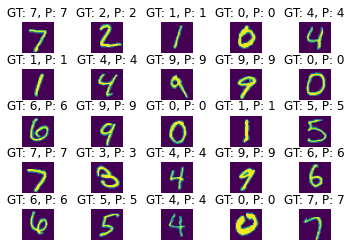

In [62]:
# Get indices of images that were predicted correctly
test_correct_idx=np.where(matched_label==True)[0]

# Plot first few images from test set
fig=plt.figure()
vis_cols=5
vis_rows=5
for i in range(1,1+vis_cols*vis_rows):
    ax=fig.add_subplot(vis_rows,vis_cols,i)
    # Set label vs prediction as title
    ax.title.set_text("GT: "+str(test_labels[test_correct_idx[i-1]])+", P: "+str(np.argmax(A_test[-1][:,test_correct_idx[i-1]])))
    plt.axis("off")
    plt.subplots_adjust(hspace=0.5)
    plt.imshow(test_images[test_correct_idx[i-1],:,:])
plt.show()   

#### Wrong predictions

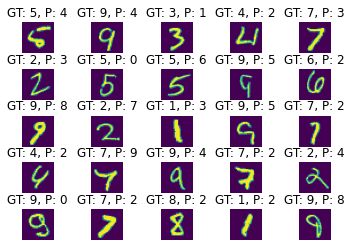

In [63]:
# Get indices of images that were predicted correctly
test_wrong_idx=np.where(matched_label==False)[0]

# Plot first few images from test set
fig=plt.figure()
vis_cols=5
vis_rows=5
for i in range(1,1+vis_cols*vis_rows):
    ax=fig.add_subplot(vis_rows,vis_cols,i)
    # Set label vs prediction as title
    ax.title.set_text("GT: "+str(test_labels[test_wrong_idx[i-1]])+", P: "+str(np.argmax(A_test[-1][:,test_wrong_idx[i-1]])))
    plt.axis("off")
    plt.subplots_adjust(hspace=0.5)
    plt.imshow(test_images[test_wrong_idx[i-1],:,:])
plt.show() 

# Problem of vanishing gradients
<a id='vanishing_grad'></a>

Coming soon...